In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

current_working_directory = os.getcwd()

# print output to the console
print(current_working_directory)


/kaggle/working


In [3]:
# necessary libraries 
import os
import PIL
import cv2
import uuid
import shutil
import random
import glob as gb
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from tqdm import tqdm  # Progress bar
from scipy.special import gamma

from keras.optimizers import *
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.metrics import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-07 15:02:55.315007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749308575.525591      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749308575.588815      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
calc_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')
calc_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_test_set.csv')
mass_train = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
mass_test = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')
dicom_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')

In [5]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [6]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [7]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path

In [8]:
# check paths
print("Cropped Image Path: ", cropped_images.iloc[0])
print("FULL Mammogram Path: ", full_mammogram.iloc[0])
print("ROI MASK Path: ", roi_mask.iloc[0])


Cropped Image Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
FULL Mammogram Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI MASK Path:  CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [9]:
# Replace the path for cropped_images to the correct directory.
correct_dir = "../input/cbis-ddsm-breast-cancer-image-dataset/jpeg"
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0]) # Print to ensure everything looks correct.


# Replace the path for full_mammogram images to the correct directory.
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0]) # Print to ensure everything looks correct.

# Replace the path for roi_mask images to the correct directory.
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0]) # Print to ensure everything looks correct.



Cropped Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg

Full mammo Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg

ROI Mask Images paths:
../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [10]:
def get_image_file_name(data, new_dict):

    for dicom in data:
        key = dicom.split('/')[4]
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")


cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)



list(cropped_images_dict.items())[:5]


list(full_mammo_dict.items())[:5]

list(roi_img_dict.items())[:5]


the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


[('1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.178994714611485132105265512043047466091',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.178994714611485132105265512043047466091/2-127.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.411833492612373627114350673042828631265/2-281.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.236373548712994183418851990043419770402/2-086.jpg'),
 ('1.3.6.1.4.1.9590.100.1.2.357008050412534761329866492500201501919',
  '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.35700805041253476132986649250020150191

In [11]:
def fix_image_path_mass(dataset):
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammo_dict:
            dataset.iloc[i, 11] = full_mammo_dict[img_name]

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]

        img_name = img[13].split("/")[2]
        if img_name in roi_img_dict:
            dataset.iloc[i, 13] = roi_img_dict[img_name]

In [12]:
fix_image_path_mass(mass_train)
fix_image_path_mass(mass_test)

In [13]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns 
mass_train.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [14]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
# view renamed columns 
mass_test.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [15]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [16]:

mass_test.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [17]:
mass_train.image_file_path[0]

'../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-211.jpg'

In [18]:
mass_test.image_file_path[0]

'../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.245063149211255120613007755642780114172/1-271.jpg'

In [19]:
mass_train[['image_file_path', 'image_view']].head()


,image_file_path,image_view
0,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
1,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
2,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
3,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
4,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO


In [20]:
mass_test[['image_file_path', 'image_view']].head()

,image_file_path,image_view
0,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
1,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
2,../input/cbis-ddsm-breast-cancer-image-dataset...,CC
3,../input/cbis-ddsm-breast-cancer-image-dataset...,MLO
4,../input/cbis-ddsm-breast-cancer-image-dataset...,CC


# CC Pathway

In [21]:
# filter to obtain only the CC views 

mass_train_cc = mass_train[mass_train['image_view'] == 'CC'].copy()
mass_test_cc = mass_test[mass_test['image_view'] == 'CC'].copy()


In [22]:
mass_train_cc.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
5,P_00009,3,RIGHT,CC,1,mass,OVAL,ILL_DEFINED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
8,P_00018,2,RIGHT,CC,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
10,P_00021,1,LEFT,CC,1,mass,OVAL,CIRCUMSCRIBED,3,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [23]:
mass_test_cc.head(5)

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
6,P_00037,3,RIGHT,CC,1,mass,ROUND,SPICULATED,5,MALIGNANT,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
9,P_00066,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,4,MALIGNANT,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


In [24]:
mass_test_cc.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [25]:
mass_train_cc.pathology.value_counts()

pathology
MALIGNANT                  296
BENIGN                     273
BENIGN_WITHOUT_CALLBACK     38
Name: count, dtype: int64

In [26]:
mass_test_cc.pathology.value_counts()

pathology
BENIGN                     94
MALIGNANT                  67
BENIGN_WITHOUT_CALLBACK    16
Name: count, dtype: int64

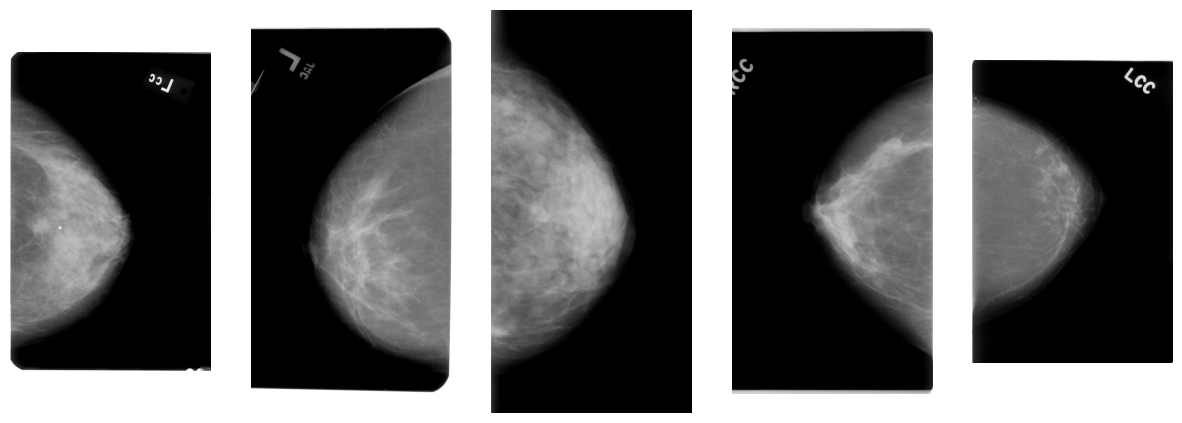

In [27]:
plot_smaples(mass_train_cc['image_file_path'].values, row=15, col=15)


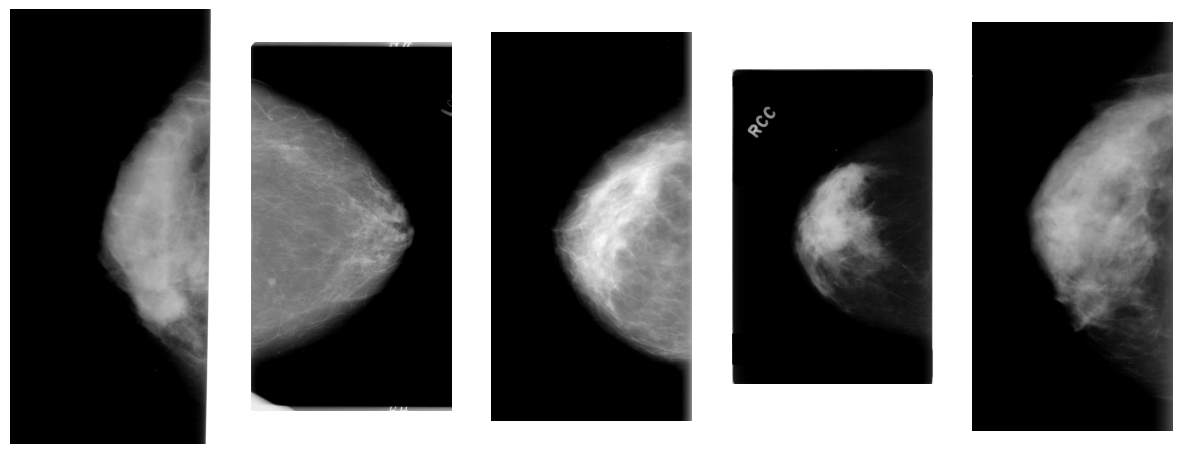

In [28]:
plot_smaples(mass_test_cc['image_file_path'].values, row=15, col=15)

In [29]:
# # given the outputs above the classes are relatively balanced ([296 vs 311 in training] and [67 vs 110 in testing]) 
# # no need of class balancing as of now

# Label Mapping and Verification

# Map pathology to binary labels (malignant = 1, benign and others ( benign_without_callback) = 0)
mass_train_cc['label'] = mass_train_cc['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_test_cc['label'] = mass_test_cc['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')

# Confirm distribution
print("Training label counts:\n", mass_train_cc['label'].value_counts())
print("Testing label counts:\n", mass_test_cc['label'].value_counts())



Training label counts:
 label
0    311
1    296
Name: count, dtype: int64
Testing label counts:
 label
0    110
1     67
Name: count, dtype: int64


In [30]:
# use only cropped_image_path (just misses out on important anatomical details)



# Data augmentation for training, basic rescale for testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1./255)

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train generator using cropped image only
train_generator_cc = train_datagen.flow_from_dataframe(
    dataframe=mass_train_cc,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test generator
test_generator_cc = test_datagen.flow_from_dataframe(
    dataframe=mass_test_cc,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 607 validated image filenames belonging to 2 classes.
Found 177 validated image filenames belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Step 1 - Load EfficientNetB0 as the base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Step 2 - Freeze the base model layers
base_model.trainable = False  # Prevents pretrained weights from being updated

# Step 3 - Build the classification model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  # Replaces Flatten for better feature extraction
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Step 4 - Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5 - Summary
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D


def build_EffB0_binary_cc(img_size=(224, 224, 3)):
    base_model = EfficientNetB0(input_shape = img_size, include_top = False, weights = 'imagenet')
    base_model.trainable = False  # Prevents pretrained weights from being updated

    
    x_cc = GlobalAveragePooling2D()(base_model.output)
    x_cc = Dense(512, activation='relu')(x_cc)
    output = Dropout(0.4)(x_cc)

    return Model(inputs=base_model.input, outputs=output)

# Build model
EffB0_model_cc = build_EffB0_binary_cc()
EffB0_model_cc.summary()

                              
                             

In [31]:
# def build_EffB0_binary_cc(img_size=(224, 224, 3), unfreeze_ratio=0.5):
#     from tensorflow.keras.applications import EfficientNetB0
#     from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
#     from tensorflow.keras.models import Model

#     base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')
    
#     # Freeze base model initially
#     for layer in base_model.layers:
#         layer.trainable = False

#     # Unfreeze last unfreeze_ratio% of layers
#     unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
#     for layer in base_model.layers[unfreeze_index:]:
#         layer.trainable = True

#     # Classification head
#     x_cc = GlobalAveragePooling2D()(base_model.output)
#     x_cc = Dense(512, activation='relu')(x_cc)
#     output = Dropout(0.4)(x_cc)



#     # ✅ Binary classification
#     # x = Dropout(0.4)(x_cc)
#     # output = Dense(1, activation='sigmoid')(x_cc)  

#     return Model(inputs=base_model.input, outputs=output)

# # Build model
# EffB0_model_cc = build_EffB0_binary_cc()
# EffB0_model_cc.summary()


I0000 00:00:1749308601.621733      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749308601.622471      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,705,956 (17.95 MB)

 Trainable params: 4,355,273 (16.61 MB)

 Non-trainable params: 350,683 (1.34 MB)

### Evaluate Feature Vectors 


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assume `feature_vectors` is your extracted feature matrix
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_features = tsne.fit_transform(feature_vectors)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap='viridis')
plt.title("t-SNE Visualization of Feature Vectors")
plt.colorbar()
plt.show()


In [ ]:
import numpy as np
import seaborn as sns

# Compute correlation matrix
corr_matrix = np.corrcoef(feature_vectors.T)

# Plot heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(feature_vectors)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='plasma')
plt.title("K-Means Clustering of Feature Vectors")
plt.show()


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(feature_vectors)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='plasma')
plt.title("K-Means Clustering of Feature Vectors")
plt.show()


In [ ]:
import shap

explainer = shap.Explainer(model.predict, feature_vectors)
shap_values = explainer(feature_vectors)

shap.summary_plot(shap_values, feature_vectors)


### Evaluate Classification Model 

In [32]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

EffB0_model_cc.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        
    ]
)


In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks to stop training early if val_loss doesn't improve and to save best weights
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_effb0_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history_cc = EffB0_model_cc.fit(
    train_generator_cc,
    epochs=10,
    validation_data=test_generator_cc,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1749308642.851644     103 service.cc:148] XLA service 0x78dac821ca50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749308642.852698     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749308642.852718     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749308646.600574     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1749308653.359701     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749308653.503789     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749308653.964719     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

 1/19 ━━━━━━━━━━━━━━━━━━━━ 19:29 65s/step - accuracy: 0.5000 - auc: 0.4688 - loss: 0.7217 - precision: 0.5000 - recall: 0.6875

I0000 00:00:1749308670.403989     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/19 ━━━━━━━━━━━━━━━━━━━━ 3s 488ms/step - accuracy: 0.5017 - auc: 0.5218 - loss: 0.6998 - precision: 0.5062 - recall: 0.6181

E0000 00:00:1749308685.443006     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749308685.587017     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749308686.056152     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1749308686.199454     101 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


19/19 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.5030 - auc: 0.5245 - loss: 0.6991 - precision: 0.5047 - recall: 0.6043 - val_accuracy: 0.6215 - val_auc: 0.5000 - val_loss: 0.6858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.4839 - auc: 0.4729 - loss: 0.7109 - precision: 0.4699 - recall: 0.5295 - val_accuracy: 0.6215 - val_auc: 0.5000 - val_loss: 0.6890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 415ms/step - accuracy: 0.5566 - auc: 0.5204 - loss: 0.6959 - precision: 0.5427 - recall: 0.4329 - val_accuracy: 0.6215 - val_auc: 0.5000 - val_loss: 0.6914 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 427ms/step - accuracy: 0.5224 - auc: 0.5290 - loss: 0.6953 - precision: 0.5146 - recall: 0.4296 - val_accuracy: 0.6215 - val_auc: 0.4761 - val_loss: 0.6921 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
1

In [34]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_auc = EffB0_model_cc.evaluate(test_generator)
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test AUC:       {test_auc:.4f}")


NameError: name 'test_generator' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
y_true = test_generator.classes
y_pred_probs = EffB0_model_cc.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Show precision, recall, f1-score
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score

# Extract metrics from history
history_dict_cc = history_cc.history
acc = history_dict_cc['accuracy']
val_acc = history_dict_cc['val_accuracy']
loss = history_dict_cc['loss']
val_loss = history_dict_cc['val_loss']

epochs_range = range(1, len(acc) + 1)

# 1. Accuracy Plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 2. Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. ROC Curve
from sklearn.metrics import roc_curve, auc

# Get true and predicted labels again (if needed)
y_true = test_generator.classes
y_pred_probs = EffB0_model_cc.predict(test_generator).flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 4. Precision & Recall
y_pred_binary = (y_pred_probs > 0.5).astype(int)

precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC:       {roc_auc:.4f}")


In [ ]:
# Save final model check model version 

EffB0_model_cc.save("EffB0_model_cc_version_1.h5")


# MLO view Pathway

In [ ]:

# filter to obtain only the MLO views 

mass_train_mlo = mass_train[mass_train['image_view'] == 'MLO'].copy()
mass_test_mlo = mass_test[mass_test['image_view'] == 'MLO'].copy()

In [ ]:
mass_train_mlo.head(5)

In [ ]:
mass_test_mlo.head(5)

In [ ]:
mass_train_mlo.pathology.value_counts()

In [ ]:
mass_test_mlo.pathology.value_counts()

In [ ]:

# # given the outputs above the classes are relatively balanced ([341 vs 370 in training] and [100 vs 80 in testing]) 
# # no need of class balancing as of now

# Label Mapping and Verification

# Map pathology to binary labels (malignant = 1, benign and others ( benign_without_callback) = 0)
mass_train_mlo['label'] = mass_train_mlo['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')
mass_test_mlo['label'] = mass_test_mlo['pathology'].map(lambda x: '1' if x == 'MALIGNANT' else '0')

# Confirm distribution
print("Training label counts:\n", mass_train_mlo['label'].value_counts())
print("Testing label counts:\n", mass_test_mlo['label'].value_counts())



In [ ]:

plot_smaples(mass_test_mlo['image_file_path'].values, row=15, col=15)

In [ ]:

plot_smaples(mass_train_mlo['image_file_path'].values, row=15, col=15)



In [ ]:

# use only cropped_image_path (just misses out on important anatomical details)



# Data augmentation for training, basic rescale for testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10)
test_datagen = ImageDataGenerator(rescale=1./255)

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Train generator using cropped image only
train_generator_mlo = train_datagen.flow_from_dataframe(
    dataframe=mass_train_mlo,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test generator
test_generator_mlo = test_datagen.flow_from_dataframe(
    dataframe=mass_test_mlo,
    x_col='cropped_image_file_path',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


In [ ]:


def build_EffB0_binary_mlo(img_size=(224, 224, 3), unfreeze_ratio=0.5):
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    from tensorflow.keras.models import Model

    base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')
    
    # Freeze base model initially
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last unfreeze_ratio% of layers
    unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True

    # Classification head
    x_mlo = GlobalAveragePooling2D()(base_model.output)
    x_mlo = Dense(512, activation='relu')(x_mlo)
    output = Dropout(0.4)(x_mlo)
    
    
    # binary classification to check model performance ()
    # x_mlo = Dropout(0.4)(x_mlo)
    # output = Dense(1, activation='sigmoid')(x_mlo)  #Binary classification

    return Model(inputs=base_model.input, outputs=output)

# Build model
EffB0_model_mlo = build_EffB0_binary_mlo()
EffB0_model_mlo.summary()


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

EffB0_model_mlo.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        
    ]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks to stop training early if val_loss doesn't improve and to save best weights
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_effb0_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history_mlo = EffB0_model_mlo.fit(
    train_generator_mlo,
    epochs=10,
    validation_data=test_generator_mlo,
    callbacks=[early_stop, checkpoint]
)


In [ ]:
# Evaluate on test set
test_loss, test_acc, test_precision, test_recall, test_auc = EffB0_model_mlo.evaluate(test_generator)
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test AUC:       {test_auc:.4f}")


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predictions
y_true = test_generator.classes
y_pred_probs = EffB0_model_mlo.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Show precision, recall, f1-score
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_score, recall_score

# Extract metrics from history
history_dict_mlo = history_mlo.history
acc = history_dict_mlo['accuracy']
val_acc = history_dict_mlo['val_accuracy']
loss = history_dict_mlo['loss']
val_loss = history_dict_mlo['val_loss']

epochs_range = range(1, len(acc) + 1)

# 1. Accuracy Plot
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 2. Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Training Loss')
plt.plot(epochs_range, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 3. ROC Curve
from sklearn.metrics import roc_curve, auc

# Get true and predicted labels again (if needed)
y_true = test_generator.classes
y_pred_probs = EffB0_model_mlo.predict(test_generator).flatten()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 4. Precision & Recall
y_pred_binary = (y_pred_probs > 0.5).astype(int)

precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"AUC:       {roc_auc:.4f}")


In [ ]:
# save model

EffB0_model_mlo.save("EffB0_mlo_model_version_1.h5")

# Feature Fusion

In [ ]:
# create paired data generator


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

def build_feature_extractor(img_size=(224,224,3), unfreeze_ratio=0.5):
    from tensorflow.keras.applications import EfficientNetB0
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
    
    base_model = EfficientNetB0(input_shape=img_size, include_top=False, weights='imagenet')

    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze last unfreeze_ratio % of layers
    unfreeze_index = int(len(base_model.layers) * (1 - unfreeze_ratio))
    for layer in base_model.layers[unfreeze_index:]:
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)

    return Model(inputs=base_model.input, outputs=x)


In [ ]:

# Use these feature extractors for both CC and MLO inputs, then concatenate their outputs, add some fully connected layers, and output final prediction.


from tensorflow.keras.layers import concatenate, Dense, Input
from tensorflow.keras.models import Model

# Inputs
input_cc = Input(shape=(224,224,3))
input_mlo = Input(shape=(224,224,3))

# Feature extractors
feature_extractor_cc = build_feature_extractor()
feature_extractor_mlo = build_feature_extractor()

# Get feature vectors
features_cc = feature_extractor_cc(input_cc)
features_mlo = feature_extractor_mlo(input_mlo)

# Concatenate features
combined_features = concatenate([features_cc, features_mlo])

# Fully connected layers after fusion
x = Dense(256, activation='relu')(combined_features)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification output

fusion_model = Model(inputs=[input_cc, input_mlo], outputs=output)
fusion_model.summary()


In [ ]:
# compile the fusion model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC

fusion_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)


In [ ]:
# train fusion model
train_combined_gen = combined_generator(train_generator_cc, train_generator_mlo)
val_combined_gen = combined_generator(test_generator_cc, test_generator_mlo)

fusion_model.fit(
    train_combined_gen,
    validation_data=val_combined_gen,
    steps_per_epoch=len(train_generator_cc),
    validation_steps=len(test_generator_cc),
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


In [ ]:

#  Combine CC and MLO Models for Fusion:




from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model

def build_fusion_model(cc_model, mlo_model):
    # Define input layers (must match individual models)
    input_cc = Input(shape=(224, 224, 3), name='input_cc')
    input_mlo = Input(shape=(224, 224, 3), name='input_mlo')

    # Get feature vectors
    feat_cc = cc_model(input_cc)
    feat_mlo = mlo_model(input_mlo)

    # Fuse features (concatenate)
    fused = Concatenate()([feat_cc, feat_mlo])  # Shape: (batch_size, 1024)

    # Classification head after fusion
    x = Dense(256, activation='relu')(fused)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    # Full fusion model
    model = Model(inputs=[input_cc, input_mlo], outputs=output)

    return model


In [ ]:
# Build the models
cc_feature_model = build_EffB0_binary_cc()
mlo_feature_model = build_EffB0_binary_mlo()

# Build fusion model
fusion_model = build_fusion_model(cc_feature_model, mlo_feature_model)
fusion_model.summary()
